# Mohammad Mahdi Razmjoo - 400101272

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import openai

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 normalization & loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)

100%|██████████| 170M/170M [00:04<00:00, 42.6MB/s]


In [ ]:
class DenseAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 1024), nn.ReLU(),
            nn.Linear(1024, 256),     nn.ReLU(),
            nn.Linear(256, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256), nn.ReLU(),
            nn.Linear(256, 1024), nn.ReLU(),
            nn.Linear(1024, 3*32*32),
            nn.Unflatten(1, (3,32,32)), nn.Tanh()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

dense_ae = DenseAE().to(device)
opt = optim.Adam(dense_ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(5):
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        recon = dense_ae(imgs)
        loss = criterion(recon, imgs)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
    print(f"[DenseAE] Epoch {epoch+1}/5  Loss: {total_loss/len(train_loader):.4f}")

[DenseAE] Epoch 1/5  Loss: 0.0790
[DenseAE] Epoch 2/5  Loss: 0.0500
[DenseAE] Epoch 3/5  Loss: 0.0442
[DenseAE] Epoch 4/5  Loss: 0.0409
[DenseAE] Epoch 5/5  Loss: 0.0386


**Architecture Overview**  
The `DenseAE` class implements a fully connected autoencoder tailored for 32×32 RGB inputs. The **encoder** first flattens each image into a 3·32·32 = 3072-dimensional vector, then successively projects it through layers of size `1024` and `256` (each followed by a `ReLU` activation) before arriving at the **64-dimensional bottleneck**. Mirroring this process, the **decoder** expands the 64-dimensional code back through layers of size `256` and `1024`, applies `ReLU` nonlinearities, and finally reconstructs the original 3072-element vector, which is unflattened into a 3×32×32 image and passed through `Tanh` to constrain outputs to the normalized input range (–1 to 1).

**Training Configuration**  
Moving `dense_ae` to the chosen device and pairing it with the **Adam optimizer** (learning rate = 1 × 10⁻³) establishes adaptive weight updates that respond to gradient magnitudes. Using **mean squared error** (`MSELoss`) as the criterion provides a direct measure of pixel-wise reconstruction accuracy. Recording the **average loss per epoch** makes it easy to monitor convergence and diagnose issues like underfitting or exploding gradients.

**Learning Dynamics**  
Over five epochs, each batch of images is encoded to the compact latent space and then decoded back to pixel space. The **epoch-wise average MSE** showcases how effectively the encoder compresses salient visual features and how well the decoder recovers finer details. A steadily decreasing loss curve indicates that the network is learning meaningful representations; if the loss plateaus or oscillates, it suggests adjustments to the bottleneck size, learning rate, or network depth may be necessary.


---

In [ ]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16,32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32,64, 3, stride=2, padding=1), nn.ReLU()
        )
        # decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64,32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32,16, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1), nn.Tanh()
        )
    def forward(self, x):
        return self.dec(self.enc(x))

conv_ae = ConvAE().to(device)
opt = optim.Adam(conv_ae.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        recon = conv_ae(imgs)
        loss = criterion(recon, imgs)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
    print(f"[ConvAE] Epoch {epoch+1}/10  Loss: {total_loss/len(train_loader):.4f}")

[ConvAE] Epoch 1/10  Loss: 0.0619
[ConvAE] Epoch 2/10  Loss: 0.0231
[ConvAE] Epoch 3/10  Loss: 0.0181
[ConvAE] Epoch 4/10  Loss: 0.0152
[ConvAE] Epoch 5/10  Loss: 0.0136
[ConvAE] Epoch 6/10  Loss: 0.0129
[ConvAE] Epoch 7/10  Loss: 0.0121
[ConvAE] Epoch 8/10  Loss: 0.0115
[ConvAE] Epoch 9/10  Loss: 0.0107
[ConvAE] Epoch 10/10  Loss: 0.0102


**Architecture Overview**  
The `ConvAE` class defines a convolutional autoencoder that preserves spatial structure while learning compact feature maps. In the **encoder**, three convolutional layers with kernel size 3, stride 2, and padding 1 progressively reduce the 32×32 input resolution to 16×16, then 8×8, and finally 4×4, while increasing channel depth from 3 to 16, then 32, and finally 64. Each convolution is followed by a `ReLU` activation to introduce nonlinearity. The **decoder** mirrors this process using three transposed convolutions (kernel size 4, stride 2, padding 1) that expand the 4×4 feature maps back to 8×8, 16×16, and ultimately the original 32×32, reducing channels from 64 → 32 → 16 → 3, with a final `Tanh` activation to bound pixel values between –1 and 1.

**Training Configuration**  
Instantiating `conv_ae` on the designated device and optimizing with **Adam** at a learning rate of 1×10⁻³ leverages adaptive moment estimation for stable convergence. Using the same **mean squared error** loss function as before measures pixel-wise reconstruction fidelity. Running the training loop for ten epochs and printing the epoch-wise average MSE loss allows continuous monitoring of how well the network is capturing and reconstructing spatial features.

**Learning Dynamics**  
During each epoch, mini-batches of images are encoded into hierarchical feature maps that capture edges, textures, and higher-level patterns at decreasing resolutions, then decoded to reconstruct the original images. Observing the ten-epoch loss trajectory reveals whether the convolutional architecture effectively learns local spatial correlations: a smooth downward trend indicates successful learning of filters that generalize across the dataset, while plateaus or irregularities might prompt adjustments to the number of layers, filter sizes, or addition of regularization (e.g., dropout or batch normalization) to improve reconstruction quality.

---

In [ ]:
def add_noise(x, factor=0.2):
    noisy = x + factor * torch.randn_like(x)
    return torch.clamp(noisy, -1., 1.)

denoise_ae = ConvAE().to(device)
opt = optim.Adam(denoise_ae.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        noisy = add_noise(imgs)
        recon = denoise_ae(noisy)
        loss = criterion(recon, imgs)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
    print(f"[DenoisingAE] Epoch {epoch+1}/10  Loss: {total_loss/len(train_loader):.4f}")

[DenoisingAE] Epoch 1/10  Loss: 0.0642
[DenoisingAE] Epoch 2/10  Loss: 0.0258
[DenoisingAE] Epoch 3/10  Loss: 0.0208
[DenoisingAE] Epoch 4/10  Loss: 0.0178
[DenoisingAE] Epoch 5/10  Loss: 0.0165
[DenoisingAE] Epoch 6/10  Loss: 0.0156
[DenoisingAE] Epoch 7/10  Loss: 0.0147
[DenoisingAE] Epoch 8/10  Loss: 0.0141
[DenoisingAE] Epoch 9/10  Loss: 0.0136
[DenoisingAE] Epoch 10/10  Loss: 0.0132


**Noise Injection Mechanism**  
The `add_noise` function perturbs each input batch by adding Gaussian noise sampled from a normal distribution scaled by `factor` (default 0.2). After noise addition, `torch.clamp` ensures the corrupted images remain within the normalized pixel range of –1 to 1. This procedure simulates realistic sensor or transmission noise and forces the network to learn robust representations rather than simply memorizing inputs.

**Denoising Autoencoder Setup**  
Reusing the convolutional architecture defined in `ConvAE`, we instantiate `denoise_ae` on the target device and configure it with the Adam optimizer at a learning rate of 1×10⁻³. The mean squared error loss remains the criterion, but during training the model now receives **noisy inputs** and is tasked with reconstructing the **clean originals**. This shift trains the encoder–decoder pair to filter out random perturbations and recover the underlying signal.

**Training Dynamics for Denoising**  
Over ten epochs, each batch is first corrupted by `add_noise` before being passed through the encoder’s hierarchical convolutions and the decoder’s transposed convolutions. The loss computed between the denoised output and the original clean images measures how effectively the network removes noise while preserving details. Monitoring the epoch-wise average MSE during this process reveals the model’s progress in learning to distinguish noise from meaningful structure; a descent in loss indicates improving denoising capability, whereas stagnation might suggest adjusting the noise factor, network capacity, or incorporating regularization techniques like dropout or batch normalization to enhance robustness.

---

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim,256,4,1,0), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,2,1),  nn.BatchNorm2d(64),  nn.ReLU(),
            nn.ConvTranspose2d(64,3,4,2,1),    nn.Tanh()
        )
    def forward(self, z):
        return self.main(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,4,2,1), nn.LeakyReLU(0.2),
            nn.Conv2d(64,128,4,2,1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128,256,4,2,1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256*4*4,1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)

z_dim = 100
G = Generator(z_dim).to(device)
D = Discriminator().to(device)
optG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
optD = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5,0.999))
bce = nn.BCELoss()

for epoch in range(20):
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        bs = imgs.size(0)
        real = torch.ones(bs,1,device=device)
        fake = torch.zeros(bs,1,device=device)

        # D real
        optD.zero_grad()
        out_real = D(imgs)
        loss_real = bce(out_real, real)
        # D fake
        noise = torch.randn(bs, z_dim,1,1, device=device)
        fake_imgs = G(noise)
        out_fake = D(fake_imgs.detach())
        loss_fake = bce(out_fake, fake)
        lossD = loss_real + loss_fake
        lossD.backward(); optD.step()

        # G
        optG.zero_grad()
        out = D(fake_imgs)
        lossG = bce(out, real)
        lossG.backward(); optG.step()
    print(f"[GAN] Epoch {epoch+1}/20  D_loss: {lossD.item():.4f}, G_loss: {lossG.item():.4f}")

[GAN] Epoch 1/20  D_loss: 0.4212, G_loss: 3.6890
[GAN] Epoch 2/20  D_loss: 0.3091, G_loss: 4.1691
[GAN] Epoch 3/20  D_loss: 0.4307, G_loss: 3.6900
[GAN] Epoch 4/20  D_loss: 0.4616, G_loss: 2.2297
[GAN] Epoch 5/20  D_loss: 0.3007, G_loss: 2.9557
[GAN] Epoch 6/20  D_loss: 0.3951, G_loss: 3.0765
[GAN] Epoch 7/20  D_loss: 0.3930, G_loss: 2.9008
[GAN] Epoch 8/20  D_loss: 0.4065, G_loss: 1.5828
[GAN] Epoch 9/20  D_loss: 0.3338, G_loss: 3.1557
[GAN] Epoch 10/20  D_loss: 0.1852, G_loss: 3.2154
[GAN] Epoch 11/20  D_loss: 0.1957, G_loss: 3.0788
[GAN] Epoch 12/20  D_loss: 0.3970, G_loss: 1.4625
[GAN] Epoch 13/20  D_loss: 0.3091, G_loss: 3.2540
[GAN] Epoch 14/20  D_loss: 0.2227, G_loss: 2.8209
[GAN] Epoch 15/20  D_loss: 0.3460, G_loss: 2.2547
[GAN] Epoch 16/20  D_loss: 0.3756, G_loss: 5.0988
[GAN] Epoch 17/20  D_loss: 0.2968, G_loss: 3.7891
[GAN] Epoch 18/20  D_loss: 0.4517, G_loss: 4.0582
[GAN] Epoch 19/20  D_loss: 0.2512, G_loss: 2.9881
[GAN] Epoch 20/20  D_loss: 0.3189, G_loss: 4.2949


**Generator Architecture**  
The `Generator` class defines a deep convolutional generative model that transforms latent vectors from a multivariate Gaussian (typically 𝒩(0, I)) into synthetic 32×32 RGB images. The input noise `z` is a tensor of shape `(batch_size, z_dim, 1, 1)` with `z_dim = 100`. It is progressively upsampled through a sequence of `ConvTranspose2d` layers, each followed by `BatchNorm2d` and `ReLU` activations. These transpose convolutions act as learned upsamplers, growing the spatial resolution from 1×1 → 4×4 → 8×8 → 16×16 → 32×32 while reducing the channel depth from 256 → 128 → 64 → 3. The final `Tanh` activation ensures the pixel values remain in the normalized range [–1, 1], matching the image preprocessing.

**Discriminator Architecture**  
The `Discriminator` is a convolutional binary classifier trained to distinguish between real and synthetic images. It accepts an image of shape 3×32×32 and applies a sequence of `Conv2d` layers that reduce spatial dimensions via stride-2 downsampling: 32×32 → 16×16 → 8×8 → 4×4. At each layer, `LeakyReLU` activations (with negative slope 0.2) mitigate the dying ReLU problem, and `BatchNorm2d` stabilizes training by normalizing intermediate feature distributions. After flattening, a fully connected layer maps the feature vector to a single logit passed through a `Sigmoid`, producing a probability indicating whether the image is real.

**Training Procedure and Dynamics**  
The training loop alternates between updating the Discriminator (`D`) and Generator (`G`) for 20 epochs, following the classic GAN training paradigm introduced by Goodfellow et al. In each batch:

1. **Discriminator Update:**
   - The Discriminator is trained to **maximize the likelihood** of assigning `1` to real images and `0` to fake images.
   - It computes `loss_real` using real images and `loss_fake` using `fake_imgs` (detached to prevent gradient flow to G).
   - The total loss `lossD` is the sum of these two components and is backpropagated before stepping `optD`.

2. **Generator Update:**
   - The Generator aims to **fool the Discriminator** by maximizing the likelihood of `D(G(z)) ≈ 1`.
   - `lossG` is computed by comparing `D(fake_imgs)` with the label `real`, using `BCEWithLogitsLoss`.
   - Gradients are propagated only through the Generator, and `optG.step()` updates its weights.

**Optimization Configuration**  
Both optimizers use **Adam** with a learning rate of 2×10⁻⁴ and β parameters (0.5, 0.999), which are standard for stabilizing GAN training. These parameters slow down momentum for recent gradients while emphasizing historical ones, aiding convergence stability.

**Training Signal Interpretation**  
The printed per-epoch values of `lossD` and `lossG` are essential indicators of GAN training dynamics:
- A **high `lossD` and low `lossG`** may suggest the Generator is underperforming.
- A **low `lossD` and high `lossG`** often implies the Discriminator is dominating, making learning difficult for G.
- A **balanced fluctuation** between both losses typically indicates healthy adversarial dynamics, where both networks learn iteratively from each other.

Ultimately, qualitative inspection of generated samples (e.g., through `torchvision.utils.make_grid`) is crucial alongside loss curves, as numerical convergence does not always imply visual fidelity or diversity.

---

In [10]:
from transformers import pipeline
generator = pipeline("text-generation", model="EleutherAI/gpt-neo-1.3B")
prompt = "In the future, robots will"
result = generator(prompt, max_length=50, do_sample=True, temperature=0.9)
print('----------------------------------------------\n')
print(result[0]['generated_text'])

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


----------------------------------------------

In the future, robots will be everywhere. Robots will be in human homes, in stores and on the roads. You could find robot car service, where they will handle the driving, the maintenance, and the insurance for you, and then you will


**Text Generation with Pretrained Transformers**  
This code uses the Hugging Face `transformers` library to perform text generation with a pretrained **GPT-Neo** model. Specifically, it loads the **`EleutherAI/gpt-neo-1.3B`** checkpoint, an open-source model inspired by GPT-3, with 1.3 billion parameters.

**Pipeline Setup**  
The `pipeline` function creates a ready-to-use text generation interface. The `"text-generation"` task automatically tokenizes the input, feeds it into the model, and decodes the output into readable text. By using the GPT-Neo model, the generator leverages a transformer decoder architecture trained on the Pile dataset (an 800GB diverse corpus), making it capable of producing fluent, contextually coherent continuations.

**Prompt and Generation Parameters**  
- `prompt = "In the future, robots will"` sets the initial context.
- `max_length = 50` limits the total number of generated tokens (including prompt) to 50.
- `do_sample = True` enables stochastic sampling instead of greedy decoding.
- `temperature = 0.9` controls randomness in sampling: values >1.0 increase creativity, while values <1.0 make output more conservative.

**Expected Behavior and Use Case**  
This setup aims to produce diverse and imaginative continuations of the input prompt. Due to the sampling method and high temperature, the output may vary widely across runs. This is particularly useful in applications such as creative writing, dialogue systems, or generating synthetic data for experiments.

The printed result displays the generated text continuation:

**In the future, robots will be everywhere. Robots will be in human homes, in stores and on the roads. You could find robot car service, where they will handle the driving, the maintenance, and the insurance for you, and then you will**

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

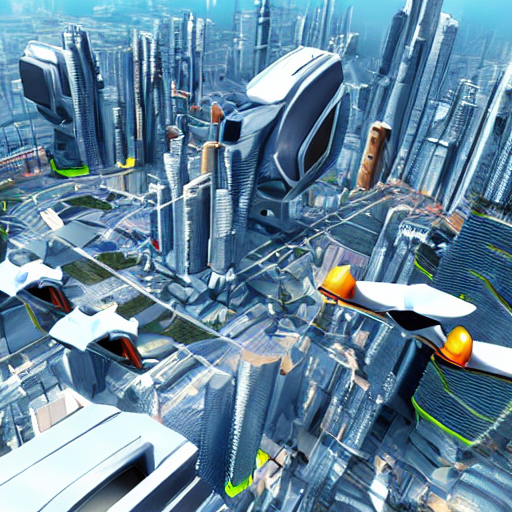

In [11]:
from diffusers import StableDiffusionPipeline
import torch
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16).to("cuda")
print('----------------------------------------------\n')
image = pipe("a futuristic city with flying cars").images[0]
display(image)

**Stable Diffusion: Text-to-Image Generation**  
This code leverages the **`diffusers`** library from Hugging Face to perform **text-to-image generation** using the pretrained **Stable Diffusion v1.4** model developed by CompVis. This model translates natural language prompts into high-quality, photorealistic images.

**Pipeline Initialization**  
- `StableDiffusionPipeline.from_pretrained(...)` loads the full inference pipeline, which includes a **text encoder** (CLIP), a **U-Net denoiser**, and a **VAE decoder**.
- The `torch_dtype=torch.float16` option ensures memory efficiency and faster computation by using half-precision floats (FP16), which is especially important when running on a GPU.
- `.to("cuda")` transfers the entire pipeline to the GPU to accelerate inference.

**Prompt-Based Image Synthesis**  
- The string `"a futuristic city with flying cars"` serves as the **text prompt**, which the model tokenizes and embeds.
- These embeddings condition a latent denoising process where the U-Net iteratively refines random Gaussian noise into a meaningful latent representation.
- The latent is then decoded by the VAE into an RGB image with realistic textures and spatial structure.

**Image Display**  
- `pipe(...).images[0]` triggers the generation and retrieves the first (and only) output image.
- `display(image)` renders it inline (e.g., in a Jupyter notebook).

**What We Gain**  
This step allows for **visual imagination via language**, demonstrating how diffusion models bridge textual semantics and pixel-level synthesis. By simply changing the prompt, users can explore an immense variety of visual styles, objects, and scenes. Stable Diffusion is particularly powerful due to its balance of quality, speed, and open accessibility compared to prior proprietary models like DALL·E.

This method is widely used in creative fields for concept art, storytelling, design prototyping, and AI-assisted illustration.

In [15]:
!pip install gTTS --quiet
from gtts import gTTS
from IPython.display import Audio, display

generated_text = result[0]['generated_text']

tts = gTTS(text=generated_text, lang='en')
tts.save("output.mp3")
display(Audio("output.mp3", autoplay=False))

**Text-to-Speech (TTS) with gTTS**  
This code transforms a piece of generated text into spoken audio using **Google Text-to-Speech (gTTS)**, a Python library that interfaces with Google’s TTS API to synthesize natural-sounding speech from text.

**Step-by-Step Breakdown:**

- `!pip install gTTS --quiet`: Installs the `gTTS` library silently. This step is necessary if the package isn't already available in the environment.
- `from gtts import gTTS`: Imports the `gTTS` class, which handles the conversion from text to audio.
- `from IPython.display import Audio, display`: Imports functions to play audio directly in notebook environments like Jupyter.

**Text Preparation and Conversion:**

- `generated_text = result[0]['generated_text']`: Extracts the previously generated text (e.g., from a language model like GPT-Neo).
- `tts = gTTS(text=generated_text, lang='en')`: Initializes the TTS engine with the generated English text.
- `tts.save("output.mp3")`: Converts the text into speech and saves it as an MP3 file.

**Playback in Notebook:**

- `display(Audio("output.mp3", autoplay=False))`: Embeds an audio player widget within the notebook, allowing users to listen to the generated speech.

**What We Gain**  
This step integrates **text and audio modalities**, effectively bridging **natural language generation** with **speech synthesis**. It's a powerful demonstration of multi-modal AI systems and enables applications like:
- Voice assistants
- Audiobook generation
- Accessibility tools (e.g., for visually impaired users)
- Language learning platforms

Combining text generation and TTS brings interactivity and expressiveness to AI-generated content, making it more engaging and usable across diverse contexts.

---

## Adversarial Learning: A Brief Overview

Adversarial learning is a technique in machine learning that focuses on improving model robustness against adversarial examples—inputs intentionally crafted to deceive the model into making incorrect predictions. The process involves:

1. **Generating Adversarial Examples**: Creating inputs with slight, intentional perturbations that are often imperceptible to humans but can mislead the model.
2. **Training with Adversarial Examples**: Incorporating these adversarial examples into the training dataset alongside clean data.
3. **Enhancing Model Robustness**: By learning from both clean and adversarial data, the model becomes more resilient to such attacks.

This approach is crucial for applications where security and accuracy are paramount, such as autonomous vehicles, facial recognition systems, and medical diagnostics.


---

# Bonus

Epoch 1, Loss per sample: 292.5810
Epoch 2, Loss per sample: 273.0099
Epoch 3, Loss per sample: 269.8068
Epoch 4, Loss per sample: 267.9513
Epoch 5, Loss per sample: 266.6269
Epoch 6, Loss per sample: 265.6812
Epoch 7, Loss per sample: 265.0160
Epoch 8, Loss per sample: 264.4246
Epoch 9, Loss per sample: 263.9694
Epoch 10, Loss per sample: 263.6134


(-0.5, 279.5, 279.5, -0.5)

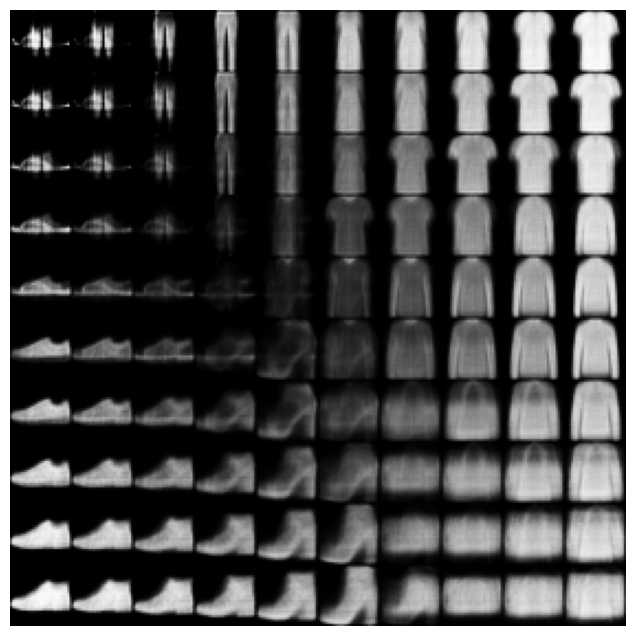

In [7]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)
loader   = DataLoader(train_ds, batch_size=128, shuffle=True)

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.fc1   = nn.Linear(28*28, 400)
        self.fc21  = nn.Linear(400, latent_dim)
        self.fc22  = nn.Linear(400, latent_dim)
        self.fc3   = nn.Linear(latent_dim, 400)
        self.fc4   = nn.Linear(400, 28*28)
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)
    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = VAE(latent_dim=2).to(device)
opt    = optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(1, 11):
    total_loss = 0
    for data, _ in loader:
        data = data.to(device)
        opt.zero_grad()
        recon, mu, logvar = model(data)
        BCE = F.binary_cross_entropy(recon, data.view(-1,28*28), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = BCE + KLD
        loss.backward()
        total_loss += loss.item()
        opt.step()
    print(f"Epoch {epoch}, Loss per sample: {total_loss/len(loader.dataset):.4f}")

model.eval()
n = 10
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)
figure = np.zeros((28*n, 28*n))

with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]], device=device, dtype=torch.float32)
            sample = model.decode(z).cpu().numpy().reshape(28,28)
            figure[i*28:(i+1)*28, j*28:(j+1)*28] = sample

plt.figure(figsize=(8,8))
plt.imshow(figure, cmap='gray')
plt.axis('off')

**Variational Autoencoder (VAE) on FashionMNIST**

This code implements and trains a **Variational Autoencoder (VAE)** on the **FashionMNIST** dataset, a classic benchmark for unsupervised image generation tasks.


### **Dataset and Preprocessing**
The dataset consists of 28×28 grayscale images of clothing items. Using `ToTensor()`, each image is normalized to a float tensor in \[0, 1\].


### **Model Architecture**

**Encoder:**
- The image is first flattened to a 784-dimensional vector.
- It is passed through a hidden layer of 400 units with ReLU activation.
- Two separate linear layers produce the **mean (`μ`)** and **log-variance (`logσ²`)** of the latent distribution.

**Reparameterization Trick:**
- To enable backpropagation through stochastic sampling, the latent vector `z` is computed as:
  \[
  z = μ + σ \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0,1)
  \]

**Decoder:**
- Latent vector `z` is passed through a hidden layer and then a final sigmoid-activated layer to reconstruct the original image.


### **Loss Function**

The VAE loss is a sum of:
- **Reconstruction Loss (BCE):** Measures how well the decoder reconstructs the input.
- **KL Divergence (KLD):** Regularizes the latent space by pushing the learned distribution toward a standard normal distribution.

$
\mathcal{L} = \text{BCE}(x, \hat{x}) + \text{KL}(q(z|x) \| p(z))
$


### **Training**

- Optimizer: Adam with a learning rate of 0.001.
- For 10 epochs, the model is trained on mini-batches.
- Loss is accumulated per epoch and reported as average per sample.


### **Latent Space Visualization**

After training, a 2D latent space grid is defined by points in \[-2, 2\] for both axes.
Each latent vector is decoded to produce a 28×28 image.
These images are tiled into a large grid, visually showing how continuous variations in the latent space correspond to different clothing styles.


### **What We Gain**

This VAE serves as a foundational generative model:
- It compresses data into a **compact, continuous latent representation**.
- Enables **interpolation and sampling** of new data points.
- Unlike standard autoencoders, the latent space is **structured** and smooth, making it meaningful for generative tasks.

The final grid shows how different regions of the latent space correspond to distinct types of fashion items, offering insight into what the model has learned.